In [99]:
# Library Imports.
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import DBjson
import json
import datetime


# Allows plots to appear directly in the notebook.
%matplotlib inline

from sklearn.linear_model import LinearRegression

In [100]:
#create a dataFrame from SQL queried info
host="dbproject.cqkm9hf5jptc.eu-west-1.rds.amazonaws.com"
port=3306
dbname="dublinbikesDB"
user="user"
password="dublinbikes"

bikesQuery = "SELECT * FROM dublinBikesInfo WHERE dateTime=(SELECT MAX(dateTIME) FROM dublinBikesInfo);"
weatherQuery = "SELECT * FROM weatherInfo WHERE dateTime=(SELECT MAX(dateTime) FROM weatherInfo);"


#try to build model with one station
oneStationAllWeather = 'SELECT * FROM dublinbikesDB.dublinBikesInfo, dublinbikesDB.weatherInfo WHERE dublinBikesInfo.dateTime = weatherInfo.dateTime AND dublinBikesInfo.stationName="BOLTON STREET";'


In [101]:
#fetch all data for one station

info = DBjson.fetchFromDB(host,port,dbname,user,password,oneStationAllWeather)

In [102]:
#make dataframe

df = pd.DataFrame(info)


In [103]:
df.head()


,clouds,dateTime,humidity,pressure,stationBanking,stationBikesAvailable,stationLastUpdate,stationLat,stationLong,stationName,...,temperature,visibility,weatherDescr,weatherID,weatherIcon,weatherInfo.dateTime,weatherMain,windDeg,windGust,windSpeed
0,75,2019-02-18 20:36:00,87,1010,0,0,0000-00-00 00:00:00,53.3512,-6.26986,BOLTON STREET,...,7,10000,broken clouds,803,04n,2019-02-18 20:36:00,Clouds,250,NaN,5
1,75,2019-02-18 20:38:00,87,1010,False,0,0000-00-00 00:00:00,53.3512,-6.26986,BOLTON STREET,...,7,10000,broken clouds,803,04n,2019-02-18 20:38:00,Clouds,250,NaN,5
2,75,2019-02-18 20:43:00,87,1010,False,0,0000-00-00 00:00:00,53.3512,-6.26986,BOLTON STREET,...,7,10000,broken clouds,803,04n,2019-02-18 20:43:00,Clouds,250,NaN,5
3,75,2019-02-18 20:44:00,87,1010,False,0,1550522290000,53.3512,-6.26986,BOLTON STREET,...,7,10000,broken clouds,803,04n,2019-02-18 20:44:00,Clouds,250,NaN,5
4,75,2019-02-19 09:11:00,75,1013,False,10,1550567375000,53.3512,-6.26986,BOLTON STREET,...,6,10000,broken clouds,803,04d,2019-02-19 09:11:00,Clouds,190,NaN,4


In [104]:
df.tail()

,clouds,dateTime,humidity,pressure,stationBanking,stationBikesAvailable,stationLastUpdate,stationLat,stationLong,stationName,...,temperature,visibility,weatherDescr,weatherID,weatherIcon,weatherInfo.dateTime,weatherMain,windDeg,windGust,windSpeed
9184,75,2019-03-31 11:48:00,81,1027,False,5,1554032486000,53.3512,-6.26986,BOLTON STREET,...,9,10000,broken clouds,803,04d,2019-03-31 11:48:00,Clouds,90,NaN,5
9185,75,2019-03-31 11:54:00,81,1027,False,5,1554033096000,53.3512,-6.26986,BOLTON STREET,...,9,10000,broken clouds,803,04d,2019-03-31 11:54:00,Clouds,90,NaN,5
9186,75,2019-03-31 12:00:00,81,1027,False,5,1554033356000,53.3512,-6.26986,BOLTON STREET,...,9,10000,broken clouds,803,04d,2019-03-31 12:00:00,Clouds,90,NaN,5
9187,75,2019-03-31 12:06:00,81,1027,False,6,1554033634000,53.3512,-6.26986,BOLTON STREET,...,9,10000,broken clouds,803,04d,2019-03-31 12:06:00,Clouds,90,NaN,5
9188,75,2019-03-31 12:12:00,81,1027,False,6,1554034243000,53.3512,-6.26986,BOLTON STREET,...,9,10000,broken clouds,803,04d,2019-03-31 12:12:00,Clouds,90,NaN,5


In [105]:
#our date range is from 18th feb to 30th March - I will use this to divide test/train manually

#create column for day of the week
df['weekday'] = df['dateTime'].dt.dayofweek

In [106]:
df['hour'] = df['dateTime'].dt.hour

In [107]:
df['minutes'] = df['dateTime'].dt.minute

In [109]:
df.size

257292

In [110]:
#divide time by half hour - new column indicates this with .0/.5

df['time'] = np.where(df['minutes'] >= 30, df.hour + 0.5, df.hour)

In [111]:
#create a rain feature
df['rain'] = np.where((df['weatherID'] >= 500) & (df['weatherID'] <= 531), 1,0)


In [112]:
#binary encode days

df['Monday'] = np.where((df['weekday'] == 0),1,0)
df['Tuesday'] = np.where((df['weekday'] == 1),1,0)
df['Wednesday'] = np.where((df['weekday'] == 2),1,0)
df['Thursday'] = np.where((df['weekday'] == 3),1,0)
df['Friday'] = np.where((df['weekday'] == 4),1,0)
df['Saturday'] = np.where((df['weekday'] == 5),1,0)
df['Sunday'] = np.where((df['weekday'] == 6),1,0)

In [129]:
#create a dataframe only with open hours - half an hour grace left after close to return bikes

#dfOpen = df[ (df.time <= 1) & (df.time > 5)]

dfOpen = df.drop(df[(df.time > 1) & (df.time < 5)].index)

In [130]:
dfOpen

,clouds,dateTime,humidity,pressure,stationBanking,stationBikesAvailable,stationLastUpdate,stationLat,stationLong,stationName,...,minutes,time,rain,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
0,75,2019-02-18 20:36:00,87,1010,0,0,0000-00-00 00:00:00,53.3512,-6.26986,BOLTON STREET,...,36,20.5,0,1,0,0,0,0,0,0
1,75,2019-02-18 20:38:00,87,1010,False,0,0000-00-00 00:00:00,53.3512,-6.26986,BOLTON STREET,...,38,20.5,0,1,0,0,0,0,0,0
2,75,2019-02-18 20:43:00,87,1010,False,0,0000-00-00 00:00:00,53.3512,-6.26986,BOLTON STREET,...,43,20.5,0,1,0,0,0,0,0,0
3,75,2019-02-18 20:44:00,87,1010,False,0,1550522290000,53.3512,-6.26986,BOLTON STREET,...,44,20.5,0,1,0,0,0,0,0,0
4,75,2019-02-19 09:11:00,75,1013,False,10,1550567375000,53.3512,-6.26986,BOLTON STREET,...,11,9.0,0,0,1,0,0,0,0,0
5,75,2019-02-19 09:45:00,75,1013,False,10,1550569431000,53.3512,-6.26986,BOLTON STREET,...,45,9.5,0,0,1,0,0,0,0,0
6,75,2019-02-19 09:46:00,75,1013,False,10,1550569431000,53.3512,-6.26986,BOLTON STREET,...,46,9.5,0,0,1,0,0,0,0,0
7,75,2019-02-19 09:47:00,75,1013,False,10,1550569431000,53.3512,-6.26986,BOLTON STREET,...,47,9.5,0,0,1,0,0,0,0,0
8,75,2019-02-19 09:48:00,75,1013,False,10,1550569431000,53.3512,-6.26986,BOLTON STREET,...,48,9.5,0,0,1,0,0,0,0,0
9,75,2019-02-19 09:54:00,75,1013,False,9,1550569970000,53.3512,-6.26986,BOLTON STREET,...,54,9.5,0,0,1,0,0,0,0,0


In [131]:
#create a dataframe for weekdays and a dataframe for weekends

dfWeekDays = dfOpen.drop(dfOpen[dfOpen.weekday >5 ].index)

dfWeekends = dfOpen.drop(dfOpen[dfOpen.weekday <6 ].index)

In [132]:
dfWeekDays.columns


Index(['clouds', 'dateTime', 'humidity', 'pressure', 'stationBanking',
       'stationBikesAvailable', 'stationLastUpdate', 'stationLat',
       'stationLong', 'stationName', 'stationStands', 'stationStatus',
       'stationStdsAvailable', 'tempMax', 'tempMin', 'temperature',
       'visibility', 'weatherDescr', 'weatherID', 'weatherIcon',
       'weatherInfo.dateTime', 'weatherMain', 'windDeg', 'windGust',
       'windSpeed', 'weekday', 'hour', 'minutes', 'time', 'rain', 'Monday',
       'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
      dtype='object')

In [133]:
#drop unused columns

dfWeekDaysR = dfWeekDays[['dateTime','time','stationBikesAvailable','rain','Monday',
       'Tuesday', 'Wednesday', 'Thursday', 'Friday']]



In [134]:
#divide into training and testing sets for weekdays

dfWDTrain = dfWeekDaysR.loc[dfWeekDaysR['dateTime'] < '2019/03/18']

In [135]:


dfWDTest = dfWeekDaysR.loc[dfWeekDaysR['dateTime'] >= '2019/03/18']

In [136]:
consideredFeatures = ['time','rain','Monday',
       'Tuesday', 'Wednesday', 'Thursday', 'Friday']
targetFeature = dfWDTrain.stationBikesAvailable

X = dfWDTrain[consideredFeatures]

multiple_linreg = LinearRegression().fit(X[consideredFeatures], targetFeature)

In [137]:
result = multiple_linreg.predict(dfWDTest[consideredFeatures])

In [148]:
type(dfWDTrain[consideredFeatures])



pandas.core.frame.DataFrame

In [139]:
for i in range(len(result)):
    print(round(result[i]))


3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
2.0
2.0
2.0
2.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0


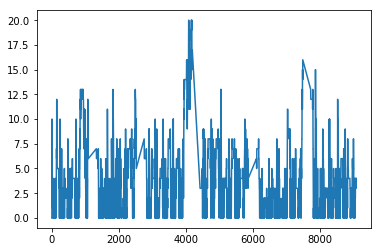

In [158]:
dfWeekDaysR['stationBikesAvailable'].plot()


In [144]:
result

array([3.34218858, 3.34218858, 3.34218858, ..., 7.7479501 , 7.7479501 ,
       7.7479501 ])

<Figure size 432x288 with 0 Axes>

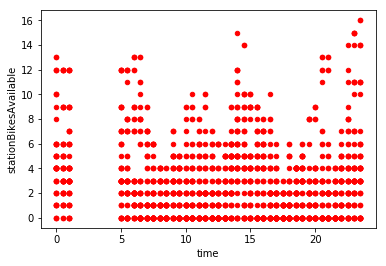

In [155]:
plt.figure()
dfWDTest.plot(kind='scatter', x='time', y='stationBikesAvailable', color='r')   

In [162]:
print("\nPredictions with multiple linear regression: \n")

#concat doesn't work because the indexes are different so I used a loop
count = 0
error = 0
print ('availBikes     prediction')
for k,v in enumerate(targetFeature):
    for y,z in enumerate (result):
        if k == y:
            print (v , '\t\t' , round(z))
            count +=1
            error += abs(v-z) #sum difference between prediction
            
print(error/count)        


Predictions with multiple linear regression: 

availBikes     prediction
0 		 3.0
0 		 3.0
0 		 3.0
0 		 3.0
10 		 3.0
10 		 3.0
10 		 3.0
10 		 3.0
10 		 3.0
9 		 3.0
8 		 3.0
7 		 3.0
5 		 3.0
5 		 3.0
4 		 3.0
2 		 3.0
2 		 3.0
1 		 3.0
1 		 3.0
1 		 3.0
1 		 3.0
2 		 3.0
2 		 3.0
2 		 3.0
2 		 3.0
2 		 3.0
2 		 3.0
3 		 3.0
3 		 3.0
2 		 3.0
2 		 3.0
2 		 3.0
2 		 3.0
0 		 3.0
1 		 3.0
1 		 3.0
1 		 3.0
1 		 3.0
2 		 3.0
2 		 3.0
2 		 3.0
0 		 3.0
0 		 3.0
0 		 3.0
1 		 3.0
1 		 3.0
2 		 3.0
2 		 3.0
2 		 3.0
2 		 3.0
3 		 3.0
4 		 3.0
4 		 3.0
2 		 3.0
1 		 3.0
0 		 3.0
0 		 3.0
0 		 3.0
0 		 3.0
0 		 3.0
1 		 3.0
1 		 3.0
1 		 3.0
1 		 3.0
2 		 3.0
2 		 3.0
2 		 3.0
2 		 3.0
0 		 3.0
0 		 3.0
0 		 3.0
0 		 3.0
0 		 3.0
0 		 3.0
0 		 3.0
1 		 3.0
1 		 3.0
0 		 3.0
0 		 3.0
0 		 3.0
0 		 3.0
0 		 3.0
0 		 3.0
1 		 3.0
1 		 3.0
1 		 3.0
1 		 3.0
1 		 3.0
0 		 3.0
1 		 3.0
3 		 3.0
0 		 3.0
1 		 3.0
1 		 3.0
1 		 3.0
1 		 3.0
2 		 3.0
2 		 3.0
2 		 3.0
2 		 3.0
1 		 3.0
1 		 3.0
1 	

0 		 8.0
0 		 8.0
0 		 8.0
0 		 8.0
0 		 8.0
4 		 8.0
5 		 8.0
3 		 8.0
3 		 8.0
3 		 8.0
3 		 8.0
2 		 8.0
2 		 8.0
0 		 8.0
1 		 8.0
0 		 8.0
2 		 8.0
0 		 8.0
0 		 8.0
0 		 8.0
0 		 8.0
1 		 8.0
0 		 8.0
1 		 8.0
2 		 8.0
4 		 8.0
4 		 8.0
3 		 8.0
3 		 8.0
2 		 8.0
2 		 8.0
2 		 8.0
2 		 8.0
2 		 8.0
2 		 8.0
2 		 8.0
2 		 8.0
2 		 8.0
2 		 8.0
1 		 8.0
1 		 8.0
1 		 8.0
2 		 8.0
2 		 8.0
0 		 8.0
0 		 8.0
2 		 8.0
2 		 8.0
2 		 8.0
3 		 8.0
3 		 8.0
3 		 8.0
2 		 8.0
1 		 8.0
2 		 8.0
2 		 8.0
2 		 8.0
3 		 8.0
3 		 8.0
1 		 8.0
0 		 8.0
0 		 8.0
0 		 8.0
0 		 8.0
1 		 8.0
1 		 8.0
1 		 8.0
1 		 8.0
1 		 8.0
1 		 8.0
1 		 8.0
1 		 8.0
1 		 8.0
1 		 8.0
1 		 8.0
1 		 8.0
1 		 8.0
1 		 8.0
1 		 8.0
1 		 8.0
1 		 8.0
1 		 8.0
1 		 8.0
2 		 8.0
2 		 8.0
3 		 8.0
3 		 8.0
3 		 8.0
4 		 8.0
3 		 8.0
2 		 8.0
0 		 8.0
0 		 8.0
0 		 8.0
0 		 8.0
0 		 8.0
0 		 8.0
2 		 8.0
3 		 3.0
3 		 3.0
3 		 3.0
3 		 3.0
1 		 3.0
0 		 3.0
0 		 3.0
0 		 3.0
6 		 3.0
5 		 3.0
5 		 3.0
4 		 3.0
4 		 3.0
0

1 		 9.0
0 		 8.0
0 		 8.0
0 		 8.0
0 		 8.0
0 		 8.0
0 		 8.0
0 		 8.0
0 		 8.0
0 		 8.0
1 		 8.0
2 		 8.0
2 		 8.0
0 		 8.0
0 		 8.0
0 		 8.0
0 		 8.0
0 		 8.0
0 		 8.0
1 		 8.0
2 		 8.0
2 		 8.0
3 		 8.0
3 		 8.0
4 		 8.0
4 		 8.0
5 		 8.0
5 		 8.0
6 		 8.0
7 		 8.0
7 		 8.0
7 		 8.0
7 		 8.0
7 		 8.0
7 		 8.0
7 		 8.0
7 		 8.0
7 		 8.0
6 		 8.0
6 		 8.0
6 		 8.0
6 		 8.0
6 		 8.0
5 		 8.0
5 		 8.0
4 		 8.0
3 		 8.0
3 		 8.0
3 		 8.0
3 		 8.0
3 		 8.0
3 		 8.0
3 		 8.0
3 		 8.0
4 		 8.0
4 		 8.0
4 		 8.0
4 		 8.0
4 		 8.0
4 		 8.0
4 		 8.0
4 		 8.0
4 		 8.0
4 		 8.0
4 		 8.0
4 		 8.0
4 		 8.0
4 		 8.0
4 		 8.0
4 		 8.0
4 		 8.0
4 		 8.0
5 		 8.0
6 		 8.0
6 		 8.0
6 		 8.0
6 		 8.0
6 		 8.0
6 		 8.0
5 		 8.0
5 		 8.0
5 		 8.0
5 		 8.0
5 		 8.0
5 		 8.0
5 		 8.0
5 		 8.0
4 		 8.0
4 		 8.0
4 		 8.0
3 		 8.0
3 		 8.0
0 		 8.0
0 		 8.0
0 		 8.0
0 		 8.0
1 		 8.0
2 		 8.0
3 		 8.0
0 		 8.0
4 		 8.0
4 		 8.0
7 		 8.0
10 		 8.0
10 		 8.0
8 		 8.0
8 		 8.0
7 		 8.0
7 		 8.0
6 		 8.0
6 		 8.0